Setup

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from ultralytics import YOLO
from PIL import Image, ImageDraw
import random

In [ ]:
# Modelo treinado previamente treinado em outro notebook
trained_model_path = YOLO(os.path.join('best.pt'))

# Dataset para usar futuramente em novos treinos e testes de inferencia
#dataset_path = '/kaggle/input/pothole-image-segmentation-dataset/Pothole_Segmentation_YOLOv8'



'validation_image_dir = "/home/eduardo/PDSI-E9/pothole-detection-dataset/valid/images/"\nground_truth_dir = "/home/eduardo/PDSI-E9/pothole-detection-dataset/valid/labels/'

In [ ]:
train_images_path = os.path.join('pothole-detection-dataset', 'train', 'images')

valid_images_path = os.path.join('pothole-detection-dataset', 'valid', 'images')
labels_path = os.path.join('pothole-detection-dataset', 'valid', 'labels')

pothole-detection-dataset/valid/labels
True


Uma rápida verificação dos dados

In [ ]:
num_train_images = 0
num_valid_images = 0

train_image_sizes = set()
valid_image_sizes = set()

for filename in os.listdir(train_images_path):
    if filename.endswith('.jpg'):  
        num_train_images += 1
        image_path = os.path.join(train_images_path, filename)
        with Image.open(image_path) as img:
            train_image_sizes.add(img.size)

for filename in os.listdir(valid_images_path):
    if filename.endswith('.jpg'): 
        num_valid_images += 1
        image_path = os.path.join(valid_images_path, filename)
        with Image.open(image_path) as img:
            valid_image_sizes.add(img.size)

print(f"Número de imagens para treino: {num_train_images}")
print(f"Número de imagens para validação: {num_valid_images}")

Number of training images: 2067
Number of validation images: 16


In [ ]:
#Verificando as dimensões das imagens
if len(train_image_sizes) == 1:
    print(f"Todas as imagens de treino possuem as mesmas dimensões: {train_image_sizes.pop()}")
else:
    print("Imagens de treino possuem dimensões variáveis")

if len(valid_image_sizes) == 1:
    print(f"Todas as imagens de validação possuem as mesmas dimensões: {valid_image_sizes.pop()}")
else:
    print("Imagens de validação possuem dimensões variáveis")

All training images have the same size: (640, 640)
All validation images have the same size: (640, 640)


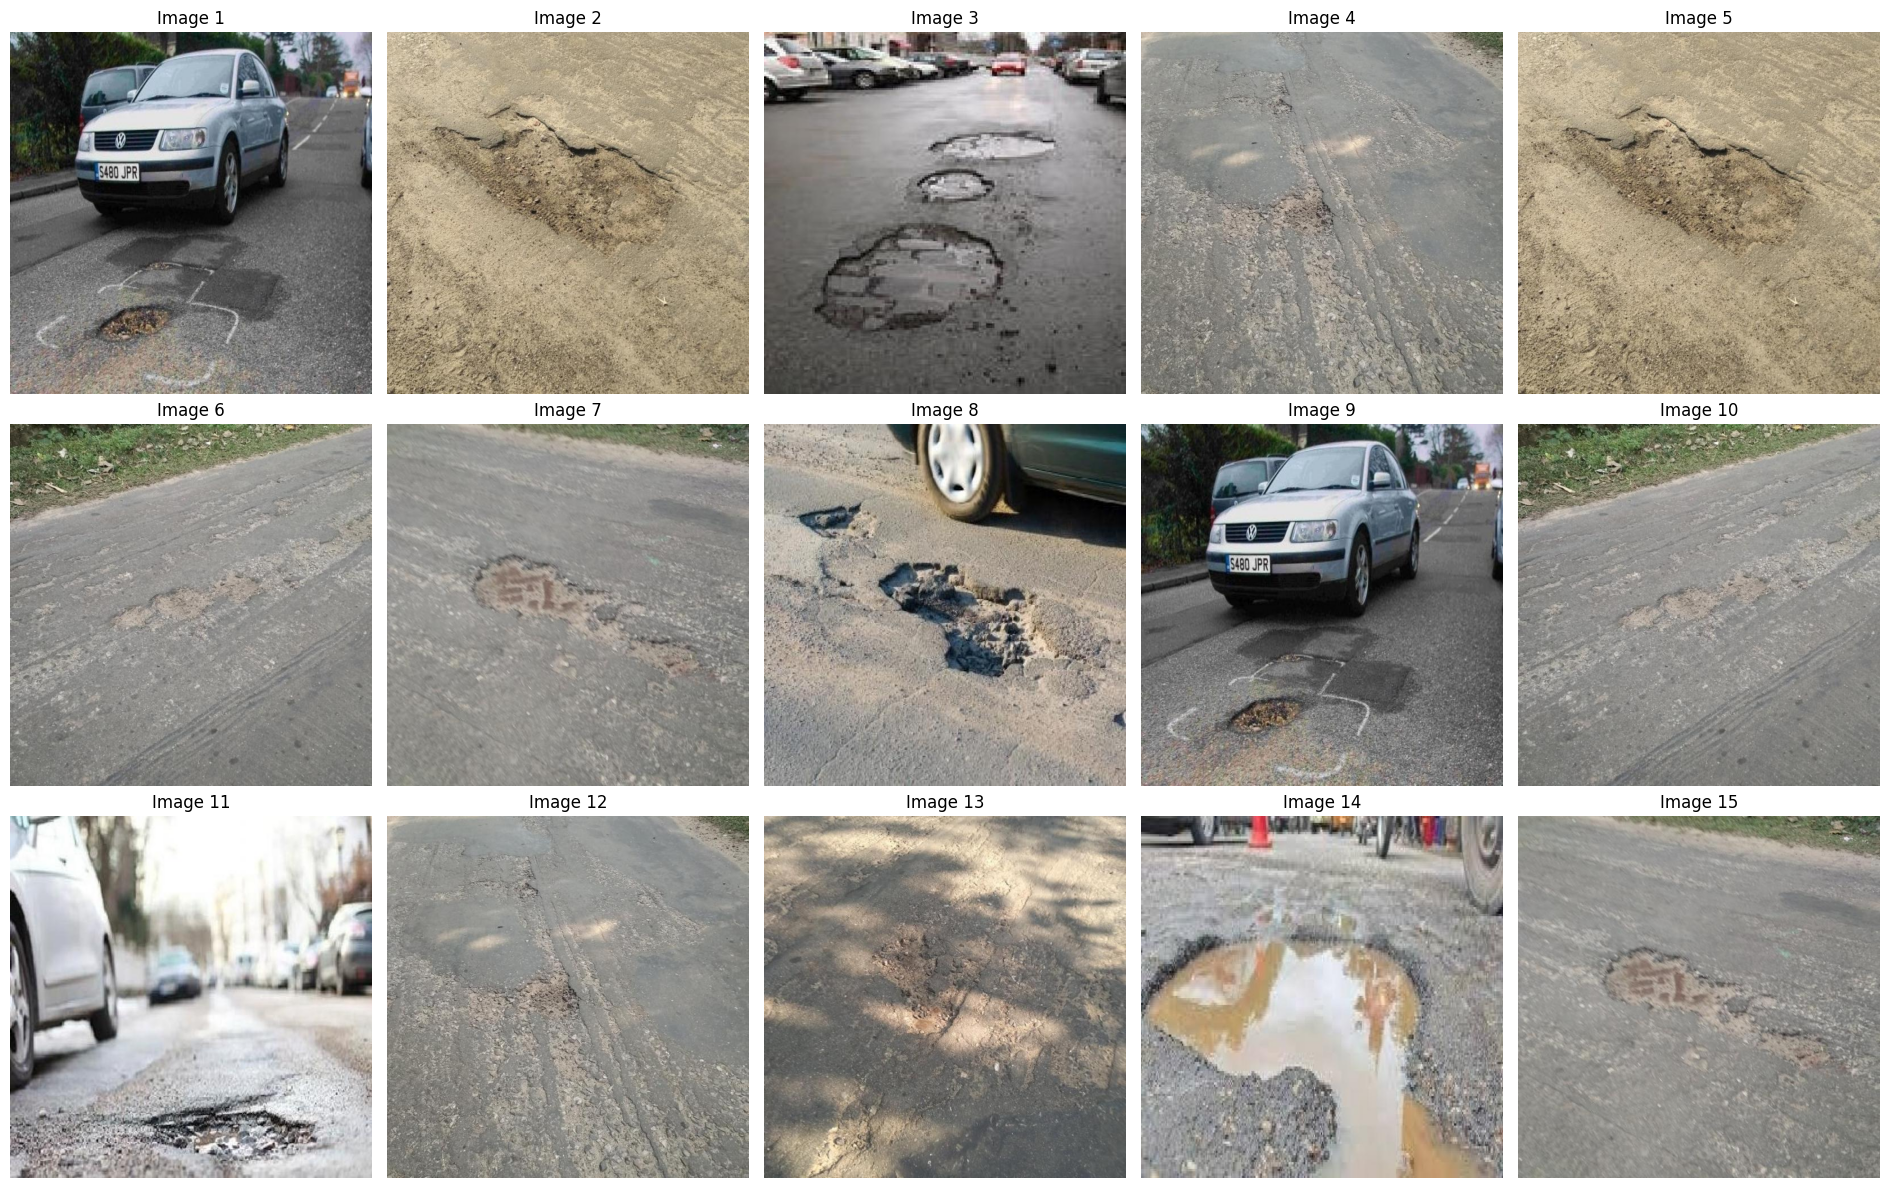

In [ ]:
#Escolhendo 15 imagens aleatórias

image_files = [f for f in os.listdir(valid_images_path) if f.endswith('.jpg')]

random_images = random.sample(image_files, 15)

plt.figure(figsize=(19, 12))

for i, image_file in enumerate(random_images):
    image_path = os.path.join(valid_images_path, image_file)
    
    img = Image.open(image_path)
    
    plt.subplot(3, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')  
    plt.title(f"Imagem {i + 1}")  

plt.tight_layout()  

In [ ]:

#Imagens para validação
validation_images = [os.path.join(valid_images_path, image_file) for i, image_file in enumerate(random_images)]


# Inferência com o modelo treinado
results = trained_model_path(validation_images, stream=False)


0: 640x640 1 pothole, 168.6ms
1: 640x640 1 pothole, 168.6ms
2: 640x640 2 potholes, 168.6ms
3: 640x640 (no detections), 168.6ms
4: 640x640 1 pothole, 168.6ms
5: 640x640 1 pothole, 168.6ms
6: 640x640 2 potholes, 168.6ms
7: 640x640 1 pothole, 168.6ms
8: 640x640 1 pothole, 168.6ms
9: 640x640 1 pothole, 168.6ms
10: 640x640 1 pothole, 168.6ms
11: 640x640 (no detections), 168.6ms
12: 640x640 1 pothole, 168.6ms
13: 640x640 1 pothole, 168.6ms
14: 640x640 2 potholes, 168.6ms
Speed: 4.2ms preprocess, 168.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


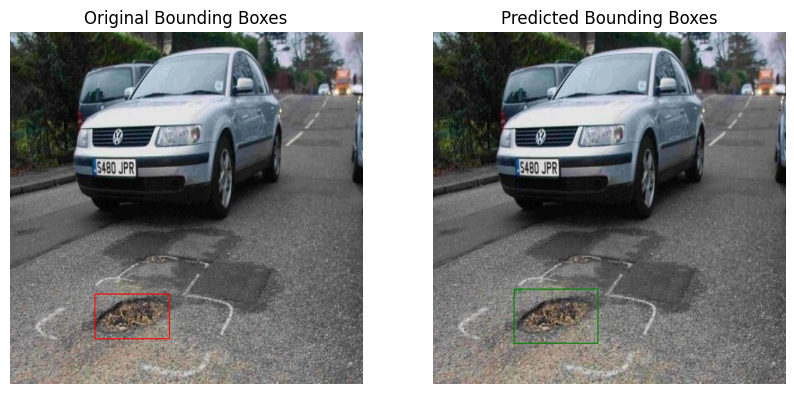

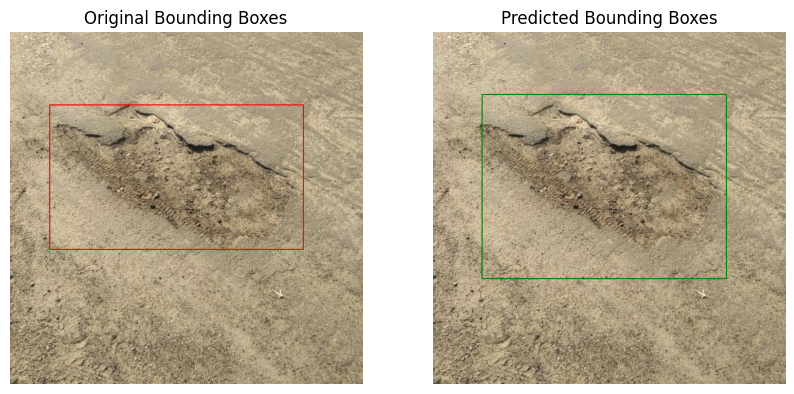

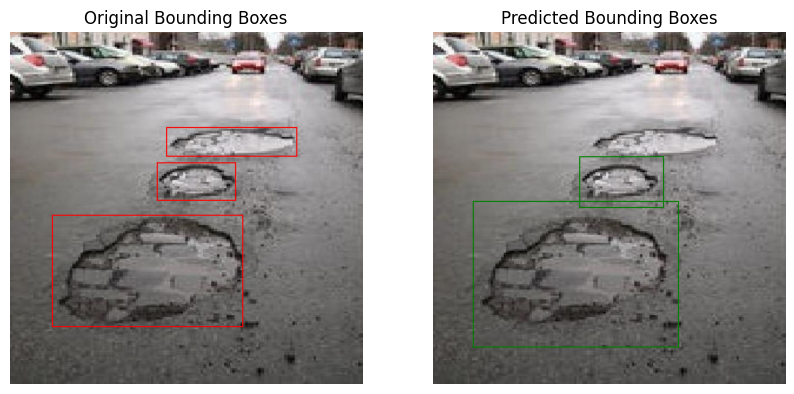

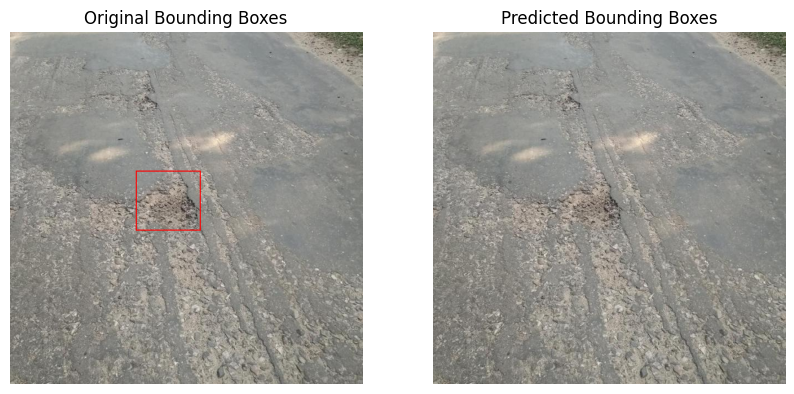

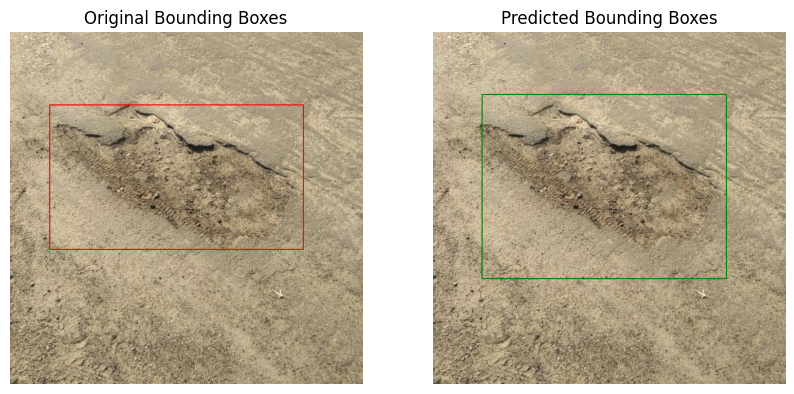

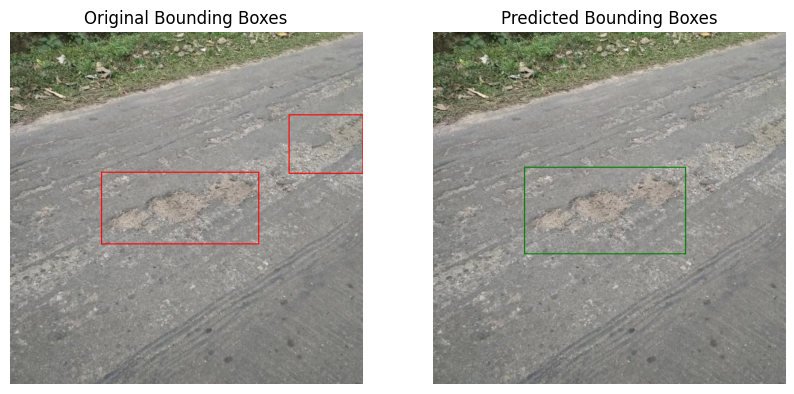

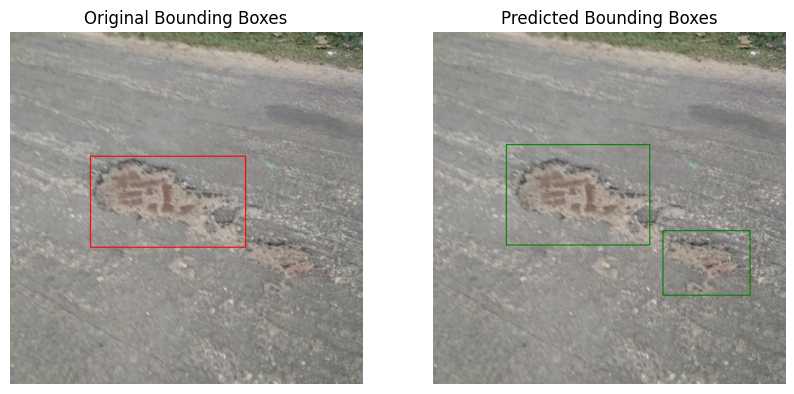

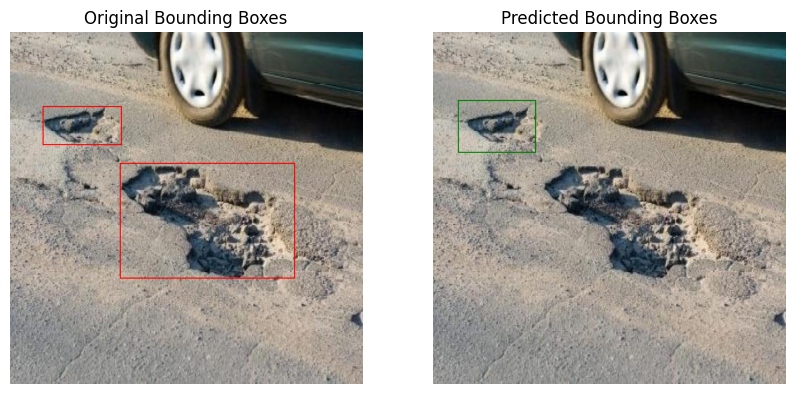

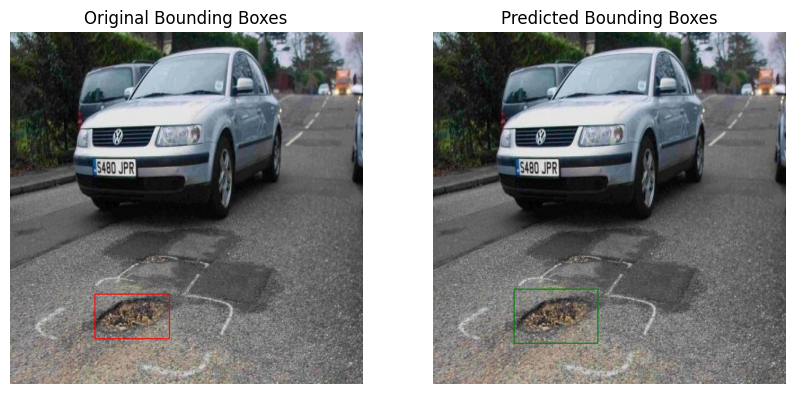

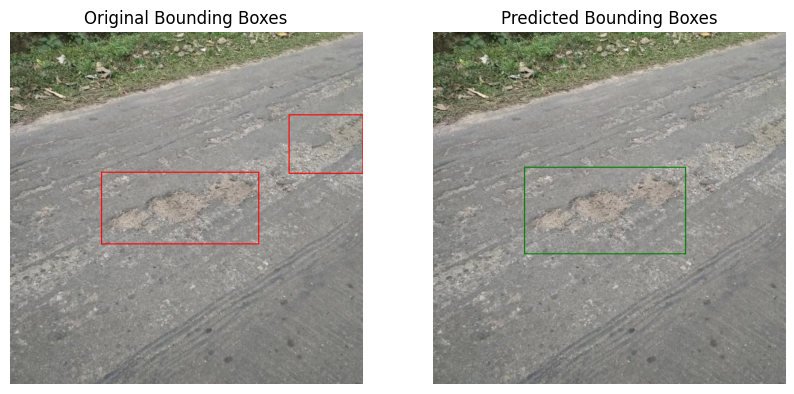

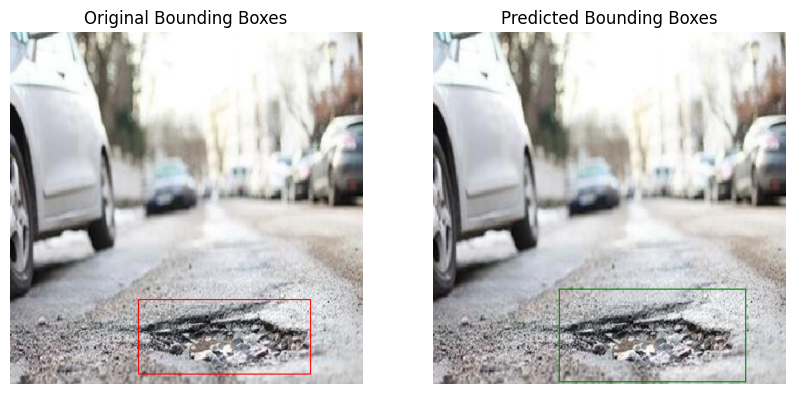

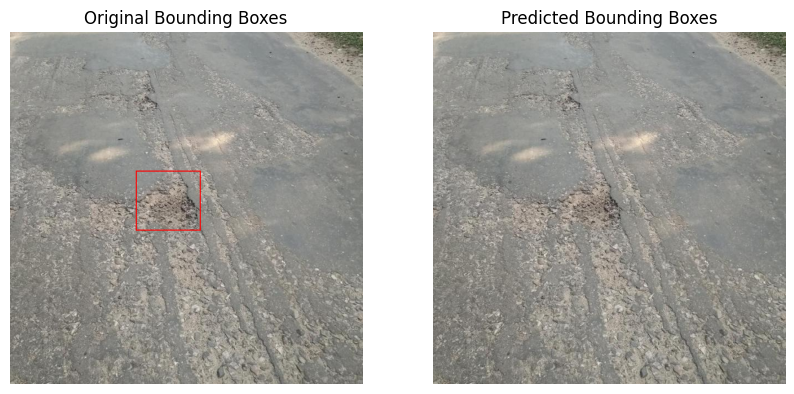

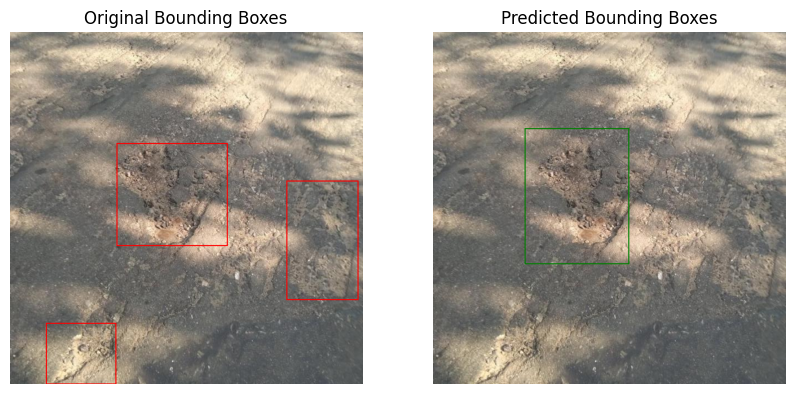

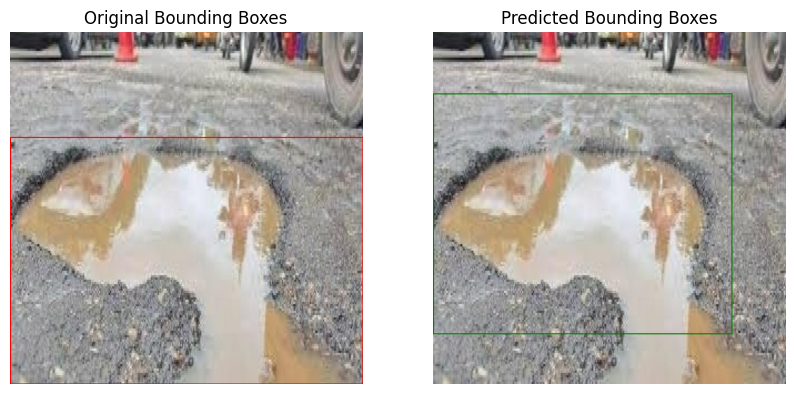

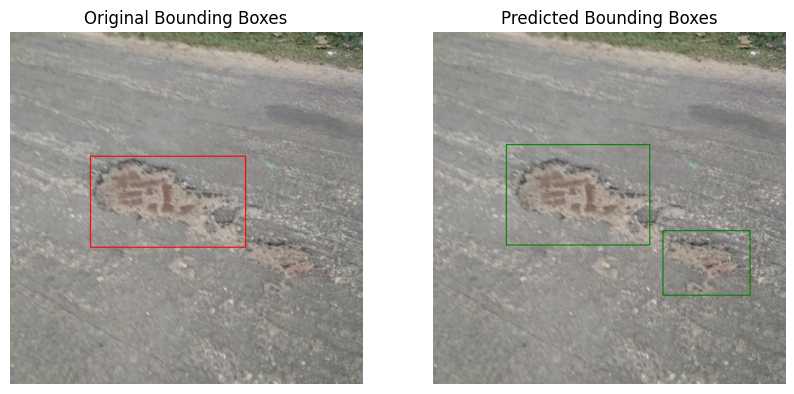

In [ ]:
# Desenhando as bounding boxes

def draw_bounding_boxes(image_path, boxes, labels=None, color='red', thickness=2):
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    for box in boxes:
        x_min, y_min, x_max, y_max = box
        draw.rectangle([x_min, y_min, x_max, y_max], outline=color, width=thickness)
        
        if labels is not None and i < len(labels):
            label = str(labels[i])
            draw.text((x_min, y_min), label, fill=color)
    
    return image

# Comparando predições
for i, result in enumerate(results):
    image_path = validation_images[i]

    pred_boxes = result.boxes.xyxy.numpy()  # xyxy format: [x_min, y_min, x_max, y_max]
    pred_labels = result.boxes.cls.numpy()  # Class ids

    image_pred = draw_bounding_boxes(image_path, pred_boxes, labels=pred_labels, color='green')

    label_path = image_path.replace('images', 'labels').replace('.jpg', '.txt')

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            original_boxes = f.readlines()

        original_boxes = [
            [float(x) for x in box.strip().split()[1:]]  
            for box in original_boxes
        ]

        # Convertendo coordenadas relativas para coordenadas absolutas
        img = Image.open(image_path)
        img_width, img_height = img.size

        original_boxes_abs = []
        for box in original_boxes:
            x_center, y_center, width, height = box
            x_min = (x_center - width / 2) * img_width
            y_min = (y_center - height / 2) * img_height
            x_max = (x_center + width / 2) * img_width
            y_max = (y_center + height / 2) * img_height
            original_boxes_abs.append([x_min, y_min, x_max, y_max])

        # Desenhando as boundig boxes originais
        image_original = draw_bounding_boxes(image_path, original_boxes_abs, color='red')

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(image_original)
        plt.title("Original Bounding Boxes")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(image_pred)
        plt.title("Predicted Bounding Boxes")
        plt.axis('off')

        plt.show()

    else:
        print(f"Label file for {image_path} not found.")

In [21]:
# IoU calculation function

def calculate_iou(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2
    
    # Calculate the area of intersection
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)
    
    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)
    
    # Calculate the area of both bounding boxes
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    
    # Calculate the area of union
    union_area = box1_area + box2_area - inter_area
    
    # Return IoU
    return inter_area / union_area if union_area > 0 else 0

# Initialize lists for true and predicted labels and bounding boxes
flatten_true_labels = []
flatten_pred_labels = []

# Iterate over the results for each image
for i, result in enumerate(results):
    image_path = validation_images[i]

    # Get the predicted bounding boxes and class ids
    pred_boxes = result.boxes.xyxy.numpy()  # xyxy format: [x_min, y_min, x_max, y_max]
    pred_labels = result.boxes.cls.numpy()  # Class ids

    # Get the path for the original label file (assuming same name as image, but with .txt extension)
    label_path = image_path.replace('images', 'labels').replace('.jpg', '.txt')

    # Read the original bounding boxes from the label file
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            original_boxes = f.readlines()

        # Parse the original boxes (YOLO format: class_id x_center y_center width height)
        original_boxes = [
            [float(x) for x in box.strip().split()[1:]]  # [x_center, y_center, width, height]
            for box in original_boxes
        ]

        # Convert relative coordinates to absolute coordinates (xyxy format)
        img = Image.open(image_path)
        img_width, img_height = img.size

        original_boxes_abs = []
        for box in original_boxes:
            x_center, y_center, width, height = box
            x_min = (x_center - width / 2) * img_width
            y_min = (y_center - height / 2) * img_height
            x_max = (x_center + width / 2) * img_width
            y_max = (y_center + height / 2) * img_height
            original_boxes_abs.append([x_min, y_min, x_max, y_max])

        # Flatten the true labels (class IDs) for the confusion matrix
        true_labels = [round(float(box[0])) for box in original_boxes]  # Round the class ID
        flatten_true_labels.extend(true_labels)

        # Matching predicted boxes with true boxes using IoU threshold
        matched_pred_boxes = []
        matched_true_boxes = []

        # Iterate over predicted boxes and match with true boxes based on IoU
        for pred_box, pred_label in zip(pred_boxes, pred_labels):
            matched = False
            for true_box, true_label in zip(original_boxes_abs, true_labels):
                iou = calculate_iou(pred_box, true_box)
                if iou > 0.5:  # IoU threshold for a match
                    flatten_pred_labels.append(pred_label)
                    flatten_true_labels.append(true_label)
                    matched_true_boxes.append(true_label)  # Ensure that matched true box is recorded
                    matched_pred_boxes.append(pred_label)
                    matched = True
                    break  # Stop once a match is found for this predicted box

            if not matched:
                flatten_pred_labels.append(pred_label)  # False positive if no match found

        # Append false negatives (true boxes with no matches)
        for true_label in true_labels:
            if true_label not in matched_true_boxes:
                flatten_true_labels.append(true_label)
                flatten_pred_labels.append(0)  # No prediction (False negative)

    else:
        print(f"Label file for {image_path} not found.")


In [10]:

# results = trained_model_path.train(
#     data=yaml_file_path,     # Path to the dataset configuration file
#     epochs=50,              # Number of epochs to train for
#     imgsz=640,               # Size of input images as integer
#     patience=10,             # Epochs to wait for no observable improvement for early stopping of training
#     batch=16,                # Number of images per batch
#     optimizer='auto',        # Optimizer to use, choices=[SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto]
#     lr0=0.0001,              # Initial learning rate 
#     lrf=0.01,                # Final learning rate (lr0 * lrf)
#     dropout=0.25,            # Use dropout regularization
#     device=0,                # Device to run on, i.e. cuda device=0 
#     seed=42                  # Random seed for reproducibility
# )



In [34]:

# Initialize variables for true positives, false positives, and false negatives
TP = 0
FP = 0
FN = 0

# Inicializa contadores para as métricas
detected_images = 0  # Imagens que tiveram pelo menos uma detecção
images_with_holes = 0  # Imagens que realmente tinham pelo menos um buraco


# Calculate the true positives (TP), false positives (FP), and false negatives (FN)
for true_label, pred_label in zip(flatten_true_labels, flatten_pred_labels):
    if true_label == pred_label:
        detected_images+=1
        images_with_holes+=1
        TP += 1  # Correct prediction (True Positive)
    elif pred_label == 0:
        images_with_holes+=1
        FN += 1  # Missed prediction (False Negative)
    else:
        detected_images+=1
        FP += 1  # Incorrect prediction (False Positive)

# Total number of true and predicted labels
total_true_labels = len(flatten_true_labels)

# Calculate accuracy percentages
if total_true_labels > 0:
    accuracy_total_detections = (TP / total_true_labels) * 100  # Accuracy based on true labels
    accuracy_pic_detections = (detected_images / images_with_holes) * 100  # Accuracy based on true labels


    print(f"Acuracia baseada na quantidade de detecções: {accuracy_total_detections:.2f}%")
    print(f"Acuracia baseada na quantidade fotos com detecções: {accuracy_pic_detections:.2f}%")

else:
    print("No labels available for calculating accuracy.")


Acuracia baseada na quantidade de detecções: 38.10%
Acuracia baseada na quantidade fotos com detecções: 72.73%
